# Comparison and validation for SEASTARex paper

### TODO:
- Pre-process L2 data for each day
- Email Ruben about X-band data for the 17th: need this ASAP to finish paper or we'll use the old results
- Remind RUI about video data - can't be included in the paper unless its delivered ASAP as there's no time to assimilate it


### Structure:
- Colocation with:
    - X-band radar data (17th)
    - MARS2D velocity vectors
    - HF radar velocity vectors (22nd, 26th)
- ADCP comparison for 22nd (and 26th?)

Group plots by day


In [1]:
import xarray as xr
import numpy as np
import scipy as sp
from scipy.io import loadmat
from scipy import interpolate, constants, signal
import matplotlib as mpl
import matplotlib.pyplot as plt
import seastar as ss
import seastar.oscar
import seastar.retrieval
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import re
import warnings
import os
import pdb
from scipy.ndimage import binary_erosion as erode
import warnings

In [2]:
# Might not be needed if this is accounted for in L1c data
def compute_radial_surface_current(level1, aux, gmf='mouche12', **kwargs):
    dswasv = seastar.gmfs.doppler.compute_wasv(level1, aux, gmf, **kwargs)
    rsc = level1.RadialSurfaceVelocity + dswasv

    return rsc
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
file_paths = ss.utils.readers._set_file_paths()
fig_folder='D:\\OneDrive - NERC\\OneDrive - NERC\\SEASTAR\\SeastarEx\\paper\\figures\\'
SMALL_SIZE = 20
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Device name = LIVPCZG-10
Setting local paths...


# 17th May


In [4]:
version = 'v20230411' # check version
flight = '20220517'
file_paths = ss.utils.readers._set_file_paths()
#DAR_tracks = ss.utils.readers._read_DAR_config(flight)
#DAR_tracks = {'Track_11':3,'Track_12':4,'Track_13':5,'Track_14':6,'Track_15':7,'Track_16':8,'Track_17':9,'Track_18':10}
tracks=['Track_1', 'Track_2']
ds_L1c = dict()
for track in tracks:
    print('Loading', track)
    ds_L1c[track] = xr.open_dataset(os.path.join(file_paths['l1c_path'],
                                                 flight + '_' + track + '_OSCAR_L1c.nc'))
#     ds_L1c[track]['RadialSurfaceVelocity'] = \
#         ds_L1c[track].RadialSurfaceVelocity\
#         .rolling(CrossRange=4).mean()\
#         .rolling(GroundRange=4).mean()
    if 'CentralWavenumber' not in ds_L1c[track] and 'CentralFreq' in ds_L1c[track]:
        ds_L1c[track] = ss.oscar.level1.add_central_electromagnetic_wavenumber(ds_L1c[track])
print('...done')

Device name = LIVPCZG-10
Setting local paths...
Loading Track_1
Loading Track_2
...done


# 22nd May

In [26]:
version = 'v20230411' # check version
flight = '20220522'
file_paths = ss.utils.readers._set_file_paths()
tracks=['Track_1', 'Track_2', 'Track_1b', 'Track_2b']
# tracks=['Track_11', 'Track_12','Track_13','Track_14']
ds_L1c = dict()
for track in tracks:
    print('Loading', track)
    ds_L1c[track] = xr.open_dataset(os.path.join(file_paths['l1c_path'],
                                                 flight + '_' + track + '_OSCAR_L1c.nc'))
#     ds_L1c[track]['RadialSurfaceVelocity'] = \
#         ds_L1c[track].RadialSurfaceVelocity\
#         .rolling(CrossRange=4).mean()\
#         .rolling(GroundRange=4).mean()
    if 'CentralWavenumber' not in ds_L1c[track] and 'CentralFreq' in ds_L1c[track]:
        ds_L1c[track] = ss.oscar.level1.add_central_electromagnetic_wavenumber(ds_L1c[track])
print('...done')

Device name = LIVPCZG-10
Setting local paths...
Loading Track_1
Loading Track_2
Loading Track_1b
Loading Track_2b
...done


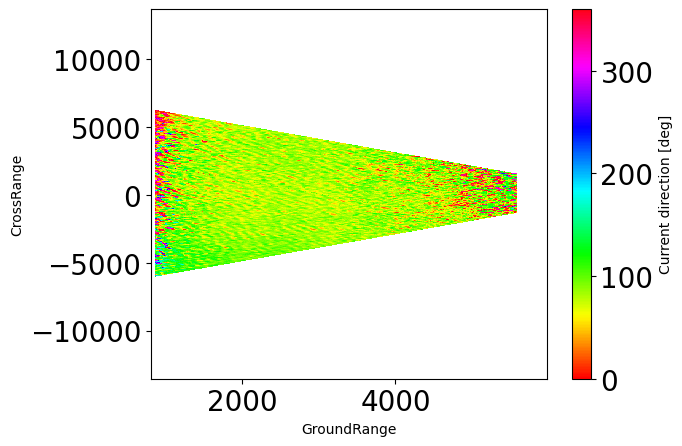

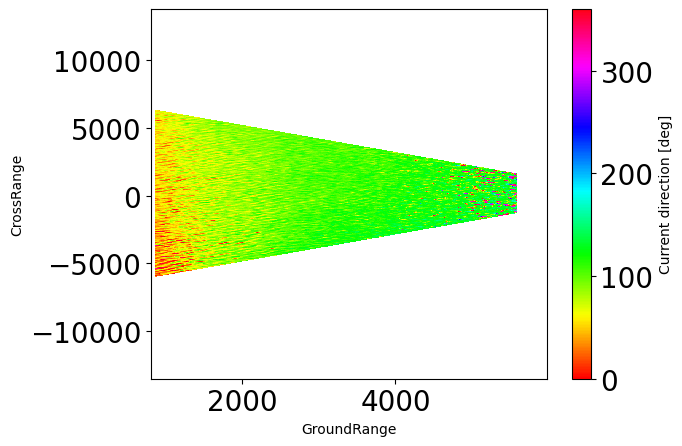

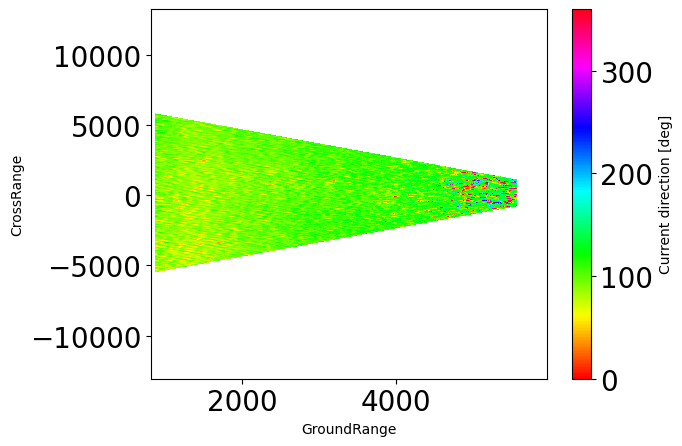

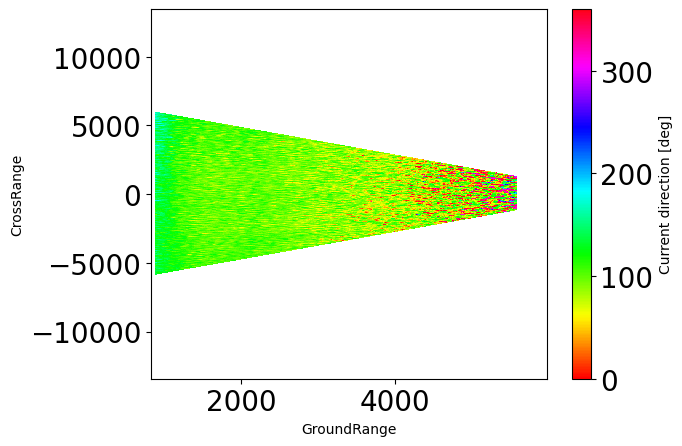

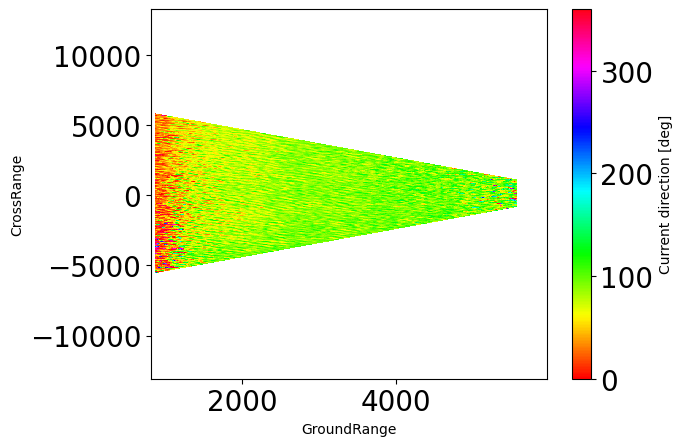

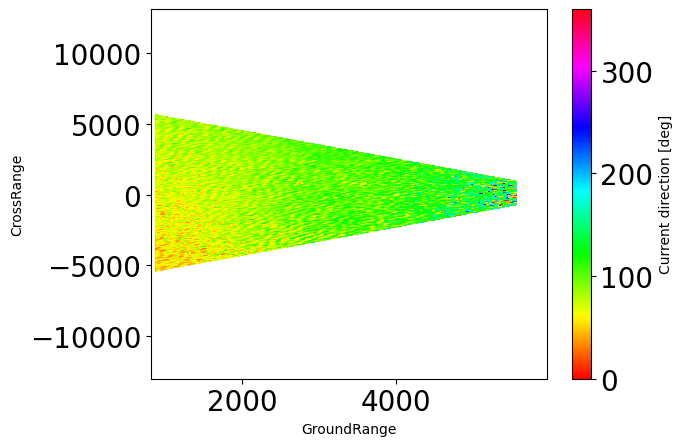

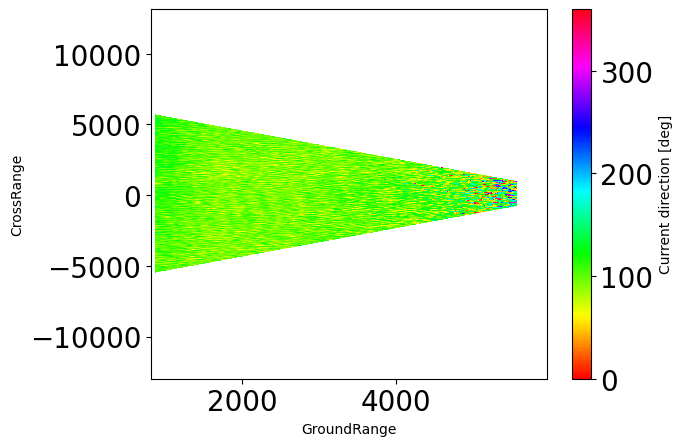

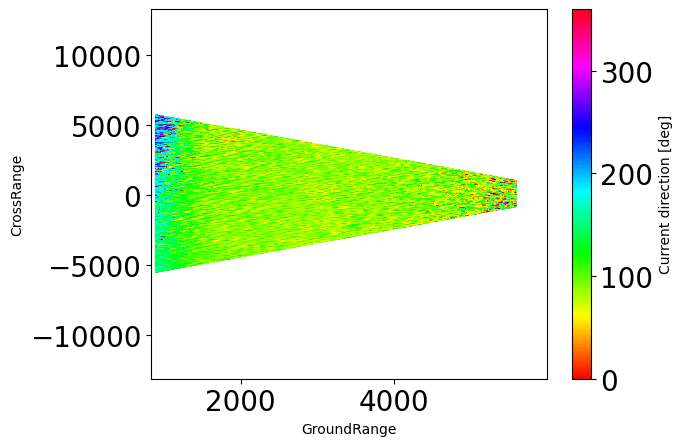

In [43]:
for track in ds_L1c.keys():
    ds_L2[track].CurrentDirection.plot(cmap='hsv',vmin=0,vmax=360)
    plt.show()

# 26th May

In [177]:
version = 'v20230411' # check version
flight = '20220526'
file_paths = ss.utils.readers._set_file_paths()
tracks=['Track_1', 'Track_2']
ds_L1c = dict()
for track in tracks:
    print('Loading', track)
    ds_L1c[track] = xr.open_dataset(os.path.join(file_paths['l1c_path'],
                                                 flight + '_' + track + '_OSCAR_L1c.nc'))
#     ds_L1c[track]['RadialSurfaceVelocity'] = \
#         ds_L1c[track].RadialSurfaceVelocity\
#         .rolling(CrossRange=4).mean()\
#         .rolling(GroundRange=4).mean()
    if 'CentralWavenumber' not in ds_L1c[track] and 'CentralFreq' in ds_L1c[track]:
        ds_L1c[track] = ss.oscar.level1.add_central_electromagnetic_wavenumber(ds_L1c[track])
print('...done')

Device name = LIVPCZG-10
Setting local paths...
Loading Track_1
Loading Track_2
...done


# L2 processing - sequential

In [5]:
def compute_current_magnitude_and_direction(level1, level2):
    """
    Compute surface current velocity and direction.

    Compute surface current velocity (m/s) and direction (degrees N)
    from radial surface current (RSC) components measured from two
    orthogonal antennas

    Parameters
    ----------
    level1 : ``xarray.Dataset``
        L1 dataset
    level2 : ``xarray.Dataset``
        L2 dataset

    Returns
    -------
    level2 : ``xarray.Dataset``
        L2 dataset
    level2.CurrentVelocity : ``xarray.DataArray``
        Magnitude of surface current velocity vector (m/s)
    level2.CurrentDirection : ``xarray.DataArray``
        Surface current direction (degrees N) in oceanographic convention

    """
    antenna_angle = np.mod(level1.sel(Antenna='Fore').AntennaAzimuthImage -
                           level1.sel(Antenna='Aft').AntennaAzimuthImage,
                           360)
    level2['CurrentVelocity'] = np.sqrt(
        level1.sel(Antenna='Fore').RadialSurfaceCurrent ** 2
        + level1.sel(Antenna='Aft').RadialSurfaceCurrent ** 2)\
        / np.sin(np.radians(antenna_angle))
    level2.CurrentVelocity.attrs['long_name'] =\
        'Current velocity'
    level2.CurrentVelocity.attrs['description'] =\
        'Total surface current velocity for each pixel in the image'
    level2.CurrentVelocity.attrs['units'] = 'm/s'
    u_1 = level1.sel(Antenna='Fore').RadialSurfaceCurrent\
        * np.sin(np.radians(level1.sel(Antenna='Fore').AntennaAzimuthImage))
    v_1 = level1.sel(Antenna='Fore').RadialSurfaceCurrent\
        * np.cos(np.radians(level1.sel(Antenna='Fore').AntennaAzimuthImage))
    u_2 = level1.sel(Antenna='Aft').RadialSurfaceCurrent\
        * np.sin(np.radians(level1.sel(Antenna='Aft').AntennaAzimuthImage))
    v_2 = level1.sel(Antenna='Aft').RadialSurfaceCurrent\
        * np.cos(np.radians(level1.sel(Antenna='Aft').AntennaAzimuthImage))

    direction = np.degrees(np.arctan2((u_1 + u_2), (v_1 + v_2)))
    ind_pos = direction < 0
    direction_corrected = np.mod(xr.where(ind_pos,
                                 180 + (180 - np.abs(direction)),
                                 direction
                                 ),
                                 360)

    level2['CurrentDirection'] = direction_corrected
    level2.CurrentDirection.attrs['long_name'] =\
        'Current direction'
    level2.CurrentDirection.attrs['description'] =\
        'Total surface current direction (oceanographic convention)'\
        ' for each pixel in the image'
    level2.CurrentDirection.attrs['units'] = 'deg'

    level2['CurrentVelocity'] = level2.CurrentVelocity.assign_coords(
        coords={'longitude': level2.longitude, 'latitude': level2.latitude})
    level2['CurrentDirection'] = level2.CurrentDirection.assign_coords(
        coords={'longitude': level2.longitude, 'latitude': level2.latitude})
    return level2

In [6]:
folder = 'restricted'
data_type = 'METEOFRANCE_AROME'
AROME_data_folder = os.path.join(file_paths['aux_path'], folder, data_type,'')
AROME_dict = dict()
AROME_file_list = os.listdir(AROME_data_folder)
for file in AROME_file_list:
    AROME_dict[AROME_file_list.index(file)] =\
    xr.open_dataset(AROME_data_folder + file)
AROME_winds = xr.concat(list(AROME_dict.values()),dim='time',join='outer')
del AROME_dict
ds_L2 = dict()
sar_pixel_size=8
rolling_window_metres=8
rolling_window = int(round(rolling_window_metres/sar_pixel_size))

gmf='mouche12'

for track in ds_L1c.keys():
    print('Processing ', track, '...')
    # Generating geophysical data fields for GMF doppler computation
    u10 = AROME_winds.u10m.interp(time=ds_L1c[track].sel(Antenna='Mid').TrackTime,method='nearest')\
        .interp(latitude=ds_L1c[track].latitude.median(), method='nearest')\
        .interp(longitude=ds_L1c[track].longitude.median(), method='nearest')
    v10 = AROME_winds.v10m.interp(time=ds_L1c[track].sel(Antenna='Mid').TrackTime,method='nearest')\
        .interp(latitude=ds_L1c[track].latitude.median(), method='nearest')\
        .interp(longitude=ds_L1c[track].longitude.median(), method='nearest')
    wind_speed, wind_direction = ss.utils.tools.windUV2SpeedDir(u10, v10)
    aux = ss.oscar.level1.init_auxiliary(ds_L1c[track].IncidenceAngleImage, wind_speed.data, wind_direction.data)
    # Compute RSC
    #ds_L1b[track] = ss.oscar.level1.compute_radial_surface_current(ds_L1b[track], aux, gmf='mouche12')
    #ds_L1b[track]  = compute_radial_surface_current(ds_L1b[track] , aux, gmf='mouche12')
#     ds_L1c[track]['RadialSurfaceVelocity'].loc[dict(Antenna='Aft')] = - ds_L1c[track].RadialSurfaceVelocity.sel(Antenna='Aft')
#     ds_L1c[track]['RadialSurfaceVelocity'].loc[dict(Antenna='Fore')] = - ds_L1c[track].RadialSurfaceVelocity.sel(Antenna='Fore')
    #     rsc = [ss.oscar.level1.compute_radial_surface_current(ds_L1c[track].sel(Antenna='Mid'),aux.sel(Antenna='Mid'),gmf=gmf),
#           ss.oscar.level1.compute_radial_surface_current(ds_L1c[track].sel(Antenna='Fore'),aux.sel(Antenna='Fore'),gmf=gmf),
#           ss.oscar.level1.compute_radial_surface_current(ds_L1c[track].sel(Antenna='Aft'),aux.sel(Antenna='Aft'),gmf=gmf)]
    rsc = [ss.oscar.level1.compute_radial_surface_current(
        ds_L1c[track].sel(Antenna=a),
        aux.sel(Antenna=a),
        gmf=gmf
    ) 
           for a in ds_L1c[track].Antenna]
    ds_L1c[track]['RadialSurfaceCurrent'] = xr.concat(rsc, 'Antenna',join='outer')
#     ds_L1c[track]['RadialSurfaceCurrent'] = ds_L1c[track].RadialSurfaceCurrent\
#         .rolling(CrossRange=4, center=True).mean()\
#         .rolling(GroundRange=4, center=True).mean()
    #L2 Processing
    # Initialise l2 dataset
    ds_L2[track] = ss.oscar.level1.init_level2(ds_L1c[track])
    # Compute current magnitude and direction
    ds_L2[track] = compute_current_magnitude_and_direction(ds_L1c[track], ds_L2[track])
    # Compute current vectors
    ds_L2[track]['CurrentVectorUComponent'], ds_L2[track]['CurrentVectorVComponent'] =\
    ss.utils.tools.currentVelDir2UV(ds_L2[track]['CurrentVelocity'], ds_L2[track]['CurrentDirection'])
    #if list(ds_L2[track].dims.keys())[0] == 'GroundRange':
    #    ds_L2[track] = ds_L2[track][["CrossRange","GroundRange"]]
print('Done...')

Processing  Track_1 ...
Processing  Track_2 ...
Done...


# Plot Oessant tracks

Possible issue encountered when converting Shape #95 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #95 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #491 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included b

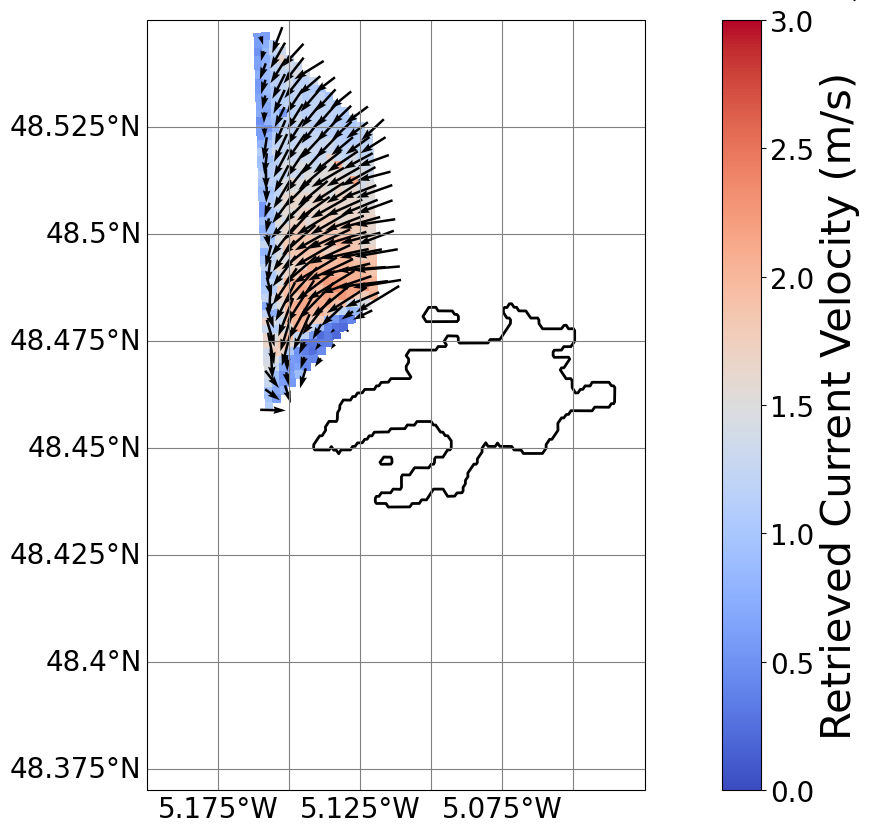

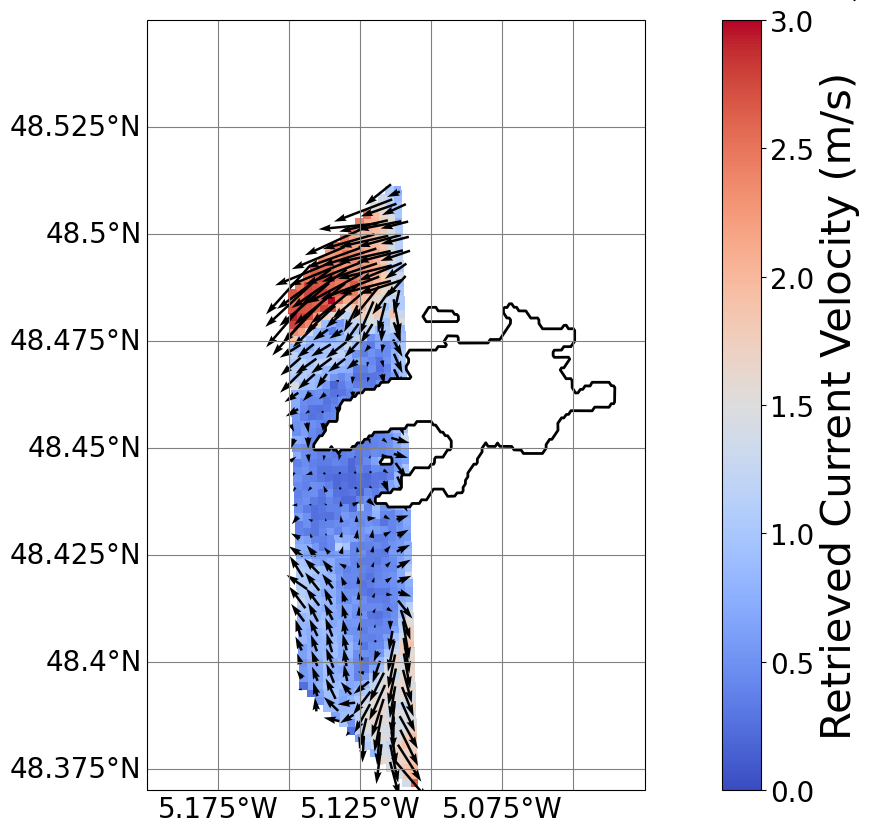

In [7]:
for track in ds_L2.keys():
# track='Track_2'
    tracktime = str(np.datetime64(ds_L1c[track].sel(Antenna='Mid').TrackTime.data,'m'))
    plot_pixel_size = 200 #pixel size in metres
    sar_pixel_size = 8
    c_factor_image = int(plot_pixel_size / sar_pixel_size)
    q_factor = 50 # Quiver plot scaling factor
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator(), frameon=True)
    im=ds_L2[track]\
    .coarsen(GroundRange=c_factor_image,boundary='trim').mean().coarsen(CrossRange=c_factor_image,boundary='trim').mean()\
    .CurrentVelocity\
    .plot(
        y='latitude',x='longitude',
        robust=True, 
        cmap='coolwarm',vmin=0, vmax=3,
        transform=ccrs.PlateCarree(),
        add_colorbar=False,
    )
    ds_L2[track]\
    .coarsen(GroundRange=q_factor,boundary='trim').mean().coarsen(CrossRange=q_factor,boundary='trim').mean()\
    .plot.quiver(
        x='longitude',y='latitude',
        u='CurrentVectorUComponent',v='CurrentVectorVComponent',
        scale=20,width=0.005,
        robust=True,
        transform=ccrs.PlateCarree()
    )
    gl=ax.gridlines(draw_labels=True, color='gray')
    gl.top_labels=False
    gl.right_labels=False
    ax.set_extent([-5.2, -5.025, 48.37, 48.55], crs=ccrs.PlateCarree())
#     ax.set_extent([-5.4, -5.1, 48.15, 48.35], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.GSHHSFeature(scale='full',facecolor='white'), linewidth=2)
    cbar = plt.colorbar(im)
    cbar.set_label('Retrieved Current Velocity (m/s)',fontsize=30)
    #plt.plot(-5.13305, 48.4166, marker="^", color='r', markersize=15, transform=ccrs.PlateCarree())
    filetime = tracktime.replace('-','')
    filetime = filetime.replace(':','')
    save_name =\
    'OSCAR_RetrievedCurrents_'+gmf+'_'+filetime
#
#     plt.savefig(fig_folder + save_name + '.png', dpi=150, bbox_inches='tight')
    plt.show()
#plt.savefig(fig_folder + 'RSC_magnitude.png', dpi=150)
#ax.set_xlabel('Latitude', fontsize=14)

# Load in Aux data

In [183]:
track='Track_2'
folder = 'unrestricted\\'
aux_file_list = os.listdir(file_paths['aux_path'] + folder)
MARS2D_files = [filename for filename in aux_file_list if 'MARS2D' in filename]
# [filename for filename in MARS2D_files if '0522' in filename]
aux_list=dict()

if flight == '20220517':
    xband_path = 'D:\\data\\SEASTAR\\SEASTARex\\Data\\Hereon\\surface_currents\\'
    aux_list['Xband'] = xr.open_dataset(xband_path+'20220517T093043.nc')
    aux_list['Xband'] = aux_list['Xband'].assign_coords({'longitude':aux_list['Xband'].longitude,
                                'latitude':aux_list['Xband'].latitude})
    cvel, cdir = ss.utils.tools.currentUV2VelDir(aux_list['Xband'].U_East.data,
                                    aux_list['Xband'].U_North.data)
    aux_list['Xband']['CurrentVelocity'] = (('y','x'), cvel)
    aux_list['Xband']['CurrentDirection'] = (('y','x'), cdir)
for data_type in ['MARS2D', 'MARS3D','HF_combined', 'WW3']:
    if bool(''.join([f for f in aux_file_list if data_type in f and flight in f])):
        aux_list[data_type] =xr.open_dataset(
            file_paths['aux_path'] + folder
            + ''.join([f for f in aux_file_list if data_type in f and flight in f])
                                            )
        
if 'MARS2D' in aux_list.keys():
    cvel, cdir = ss.utils.tools.currentUV2VelDir(aux_list['MARS2D'].U.data, aux_list['MARS2D'].V.data)
    aux_list['MARS2D']['CurrentVelocity'] = (('time','nj','ni'), cvel)
    aux_list['MARS2D']['CurrentDirection'] = (('time','nj','ni'), cdir)
    timesel = np.argmin(np.abs(aux_list['MARS2D'].time.data - ds_L1c[track].sel(Antenna='Mid').TrackTime.data))
#     aux_list['MARS2D']['L1_CurrentMagnitude_colocated'] =\
#         ss.retrieval.auxiliary.colocate_variable_lat_lon(aux_list['MARS2D'].CurrentVelocity.isel(time=timesel),
#                                                          aux_list['MARS2D'].latitude,
#                                                          aux_list['MARS2D'].longitude,
#                                                          ds_L2[track][["CrossRange","GroundRange"]]
#                                                         )
#     aux_list['MARS2D']['L1_CurrentDirection_colocated'] =\
#         ss.retrieval.auxiliary.colocate_variable_lat_lon(aux_list['MARS2D'].CurrentDirection.isel(time=timesel),
#                                                          aux_list['MARS2D'].latitude,
#                                                          aux_list['MARS2D'].longitude,
#                                                          ds_L2[track][["CrossRange","GroundRange"]]
#                                                         )
    
if 'HF_combined' in aux_list.keys():
    aux_list['HF_combined'] = aux_list['HF_combined'].assign_coords(
            coords={'longitude': aux_list['HF_combined'].longitude, 'latitude': aux_list['HF_combined'].latitude})
    cvel, cdir = ss.utils.tools.currentUV2VelDir(aux_list['HF_combined'].U.data, aux_list['HF_combined'].V.data)
    aux_list['HF_combined']['CurrentVelocity'] = (('time','lat','lon'), cvel)
    aux_list['HF_combined']['CurrentDirection'] = (('time','lat','lon'), cdir)
    aux_list['HF_combined']['CurrentVelocity'].assign_coords({'latitude':aux_list['HF_combined'].latitude,
                                                         'longitude':aux_list['HF_combined'].longitude})

# aux_list['HF_radial'] = xr.open_dataset(file_paths['aux_path'] + folder
#                             + 'HF_Brezellec_Radial_2022.nc')
# aux_list['HF_radial'] = aux_list['HF_radial'].assign_coords({"latitude":(['lon', 'lat'], aux_list['HF_combined'].latitude.data),
#                                      "longitude":(['lon', 'lat'], aux_list['HF_combined'].longitude.data)})
# aux_list['HF_radial'] = aux_list['HF_radial'].drop_duplicates('time', keep='first')
aux_list['Trefle_MLM'] = xr.open_dataset(file_paths['aux_path'] + folder + 'Trefle_MLM.nc')
aux_list['Trefle_MEM'] = xr.open_dataset(file_paths['aux_path'] + folder + 'Trefle_MEM.nc')
aux_list['Trefle_spectra'] = xr.open_dataset(file_paths['aux_path'] + folder + 'Trefle_spectra.nc')
aux_list['Trefle'] = xr.open_dataset(file_paths['aux_path'] + folder + 'TREFLE_WH300_avg.nc')
aux_list['Trefle'] = aux_list['Trefle'].assign_coords(depth=("bin", aux_list['Trefle'].depth.data))

# U_adcp=np.empty(0)
# dir_adcp=np.empty(0)
# for i in range(11,18 + 1):
#     t = ds_L2[track].TrackTime
#     vel, cdir = ss.utils.tools.currentUV2VelDir(aux_list['Trefle'].v_e.sel(time=t, method='nearest').isel(bin=0),
#                                  aux_list['Trefle'].v_n.sel(time=t, method='nearest').isel(bin=0))
#     U_adcp = np.append(U_adcp, vel)
#     dir_adcp = np.append(dir_adcp, cdir)



print('...Done')

...Done


# X-band

C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\cartopy\crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\cartopy\crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\cartopy\crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


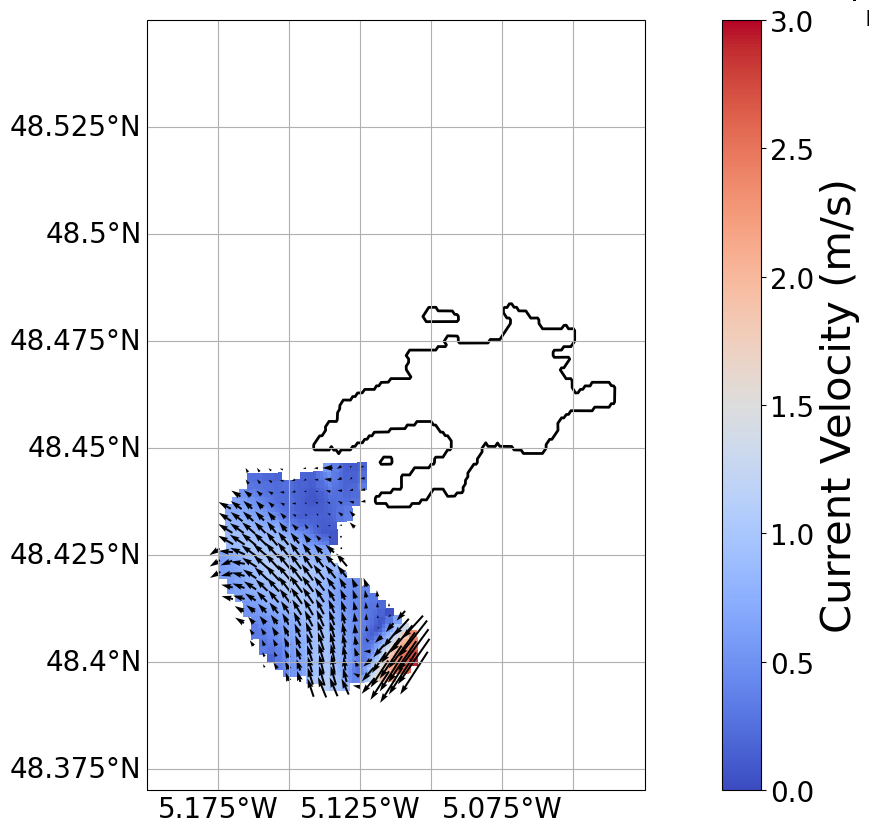

In [144]:
q_factor=40
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator())
im=aux_list['Xband'].CurrentVelocity\
.plot(
    y='latitude',
    x='longitude',
    robust=True, 
    cmap='coolwarm',
    vmin=0, vmax=3,
    transform=ccrs.PlateCarree(),
    add_colorbar=False,
)
aux_list['Xband']\
.coarsen(x=q_factor,boundary='trim').mean().coarsen(y=q_factor,boundary='trim').mean()\
.plot.quiver(
    x='longitude',
    y='latitude',
    u='U_East',
    v='U_North',
    scale=25,width=0.004,
    angles='xy',
    robust=True,
    transform=ccrs.PlateCarree()
)
ax.set_extent([-5.2, -5.025, 48.37, 48.55], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.GSHHSFeature(scale='full',facecolor='white'), linewidth=2)
gl=ax.gridlines(draw_labels=True)
gl.top_labels=False
gl.right_labels=False
cbar = plt.colorbar(im,ax=ax)
cbar.set_label('Current Velocity (m/s)',fontsize=30)
save_name ='X-band_CurrentVelocity_'+aux_list['Xband'].start_time
plt.savefig(fig_folder + save_name + '.png', dpi=150, bbox_inches='tight')
plt.show()

# MARS2D

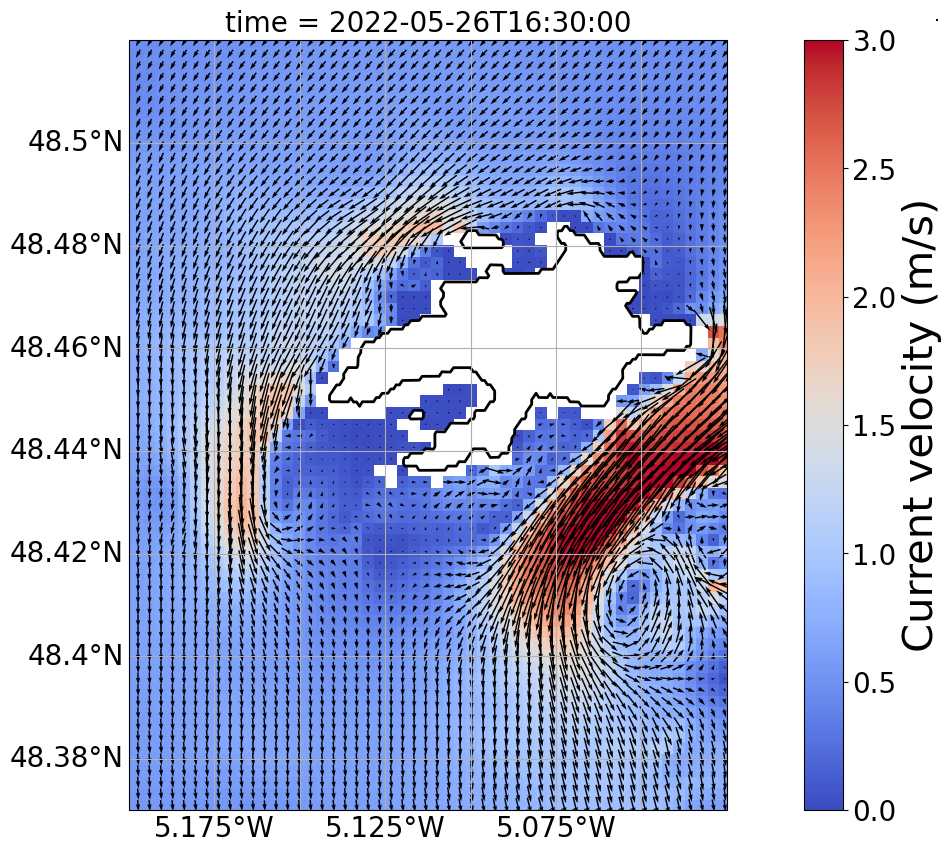

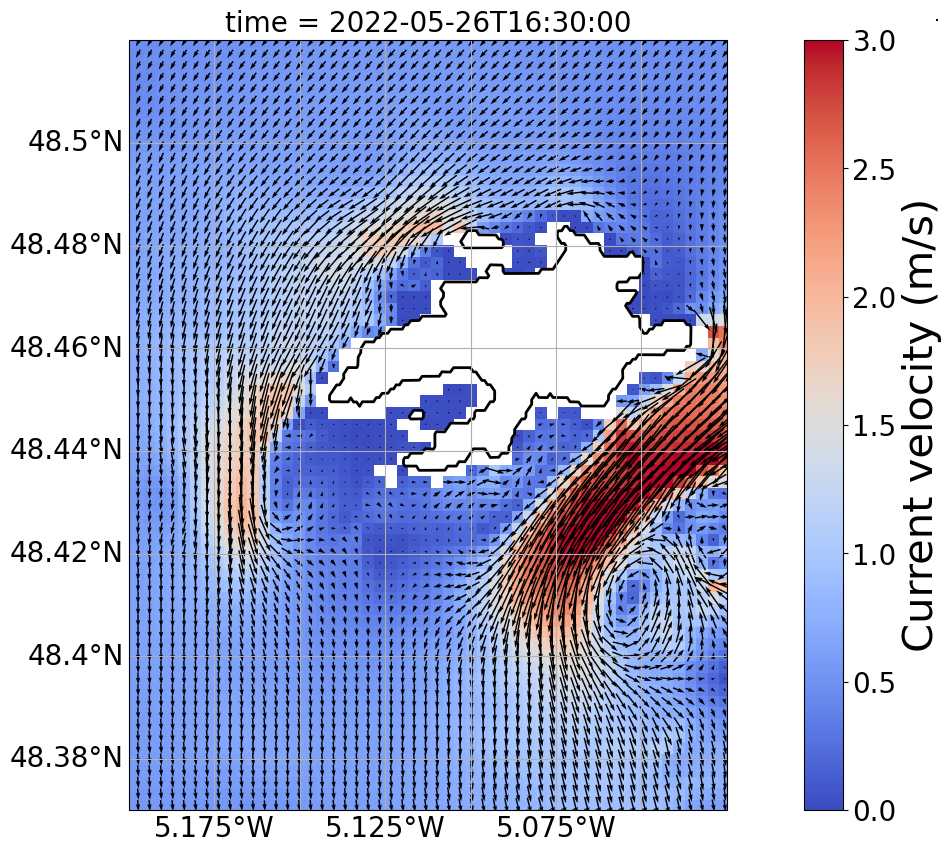

In [184]:
for track in ds_L2.keys():
    timesel = np.argmin(np.abs(aux_list['MARS2D'].time.data - ds_L1c[track].sel(Antenna='Mid').TrackTime.data))
    plot_pixel_size = 200 #pixel size in metres
    sar_pixel_size = 8
    c_factor = int(plot_pixel_size / sar_pixel_size)
    q_factor = 30 # Quiver plot scaling factor
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator())
    im = aux_list['MARS2D'].CurrentVelocity\
    .isel(time=timesel)\
    .plot(
        y='latitude',
        x='longitude',
        robust=True, 
        cmap='coolwarm',
        vmin=0, vmax=3,
        transform=ccrs.PlateCarree(),
        add_colorbar=False,
    )
    aux_list['MARS2D']['U_coloc'], aux_list['MARS2D']['V_coloc'] =\
        ss.utils.tools.currentVelDir2UV(aux_list['MARS2D'].CurrentVelocity,
                                        aux_list['MARS2D'].CurrentDirection)
    aux_list['MARS2D']\
    .isel(time=timesel)\
    .plot.quiver(
        x='longitude',
        y='latitude',
        u='U_coloc',
        v='V_coloc',
        scale=30,
        angles='xy',
        robust=True,
        transform=ccrs.PlateCarree()
    )
    #plt.title('MARS2D')
    gl=ax.gridlines(draw_labels=True)
    gl.top_labels=False
    gl.right_labels=False
    ax.set_extent([-5.2, -5.025, 48.37, 48.52], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.GSHHSFeature(scale='full',facecolor='white'), linewidth=2)
    
    cbar = plt.colorbar(im,ax=ax)
    cbar.set_label('Current velocity (m/s)',fontsize=30)
    tracktime = str(np.datetime64(aux_list['MARS2D'].time.isel(time=timesel).data,'m'))
    filetime = tracktime.replace('-','')
    filetime = filetime.replace(':','')
    save_name ='MARS2D_CurrentVelocity_'+'_'+filetime
#
    plt.savefig(fig_folder + save_name + '.png', dpi=150, bbox_inches='tight')
    plt.show()

# HF Radar

In [155]:
aux_list['HF_combined']

<xarray.Dataset>
Dimensions:           (time: 48, lat: 110, lon: 80)
Coordinates:
  * time              (time) datetime64[ns] 2022-05-22T00:04:16 ... 2022-05-2...
    latitude          (lat, lon) float32 ...
    longitude         (lat, lon) float32 ...
Dimensions without coordinates: lat, lon
Data variables:
    U                 (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    V                 (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    CurrentVelocity   (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    CurrentDirection  (time, lat, lon) float32 nan nan nan nan ... nan nan nan

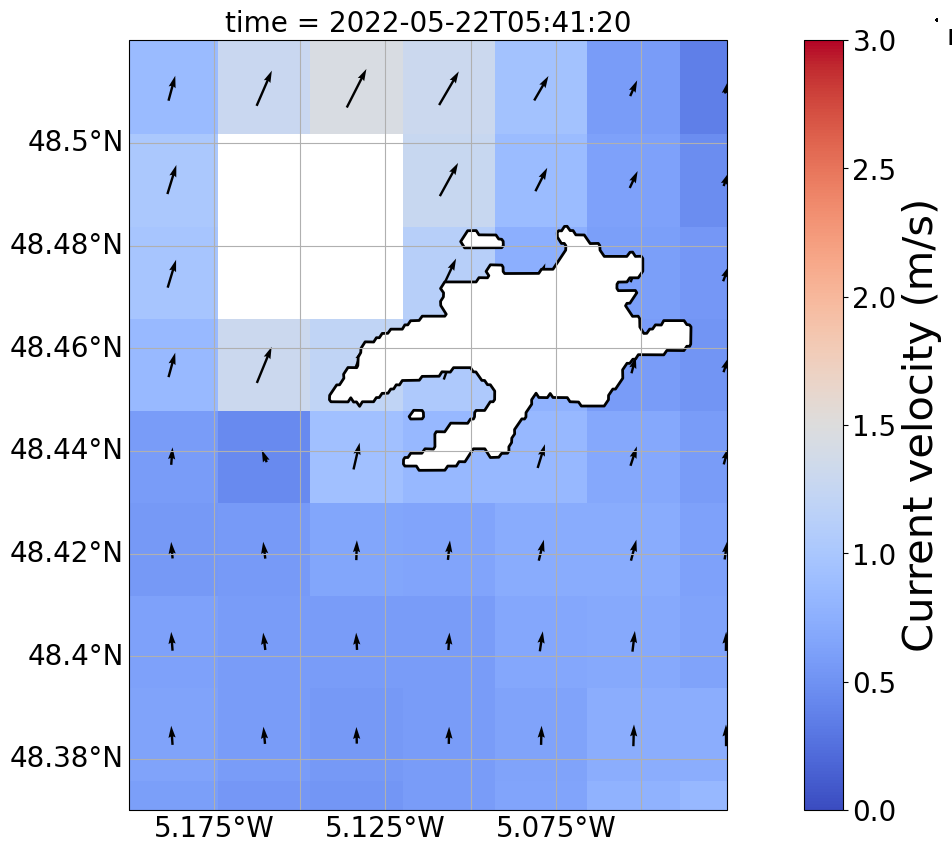

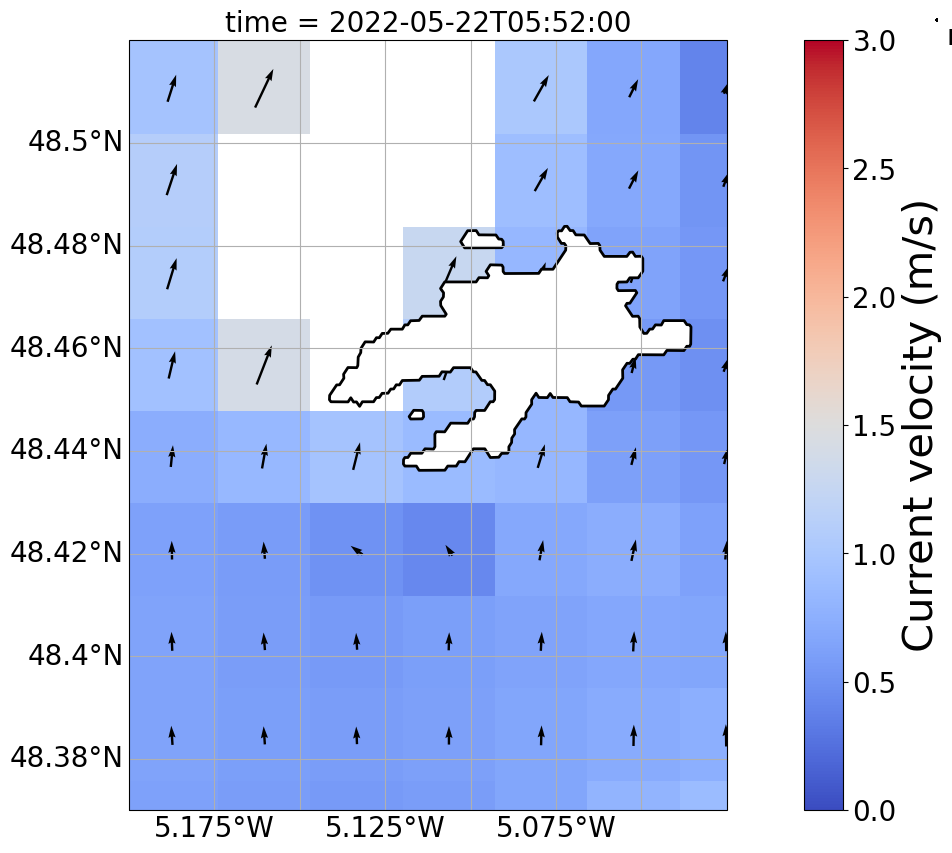

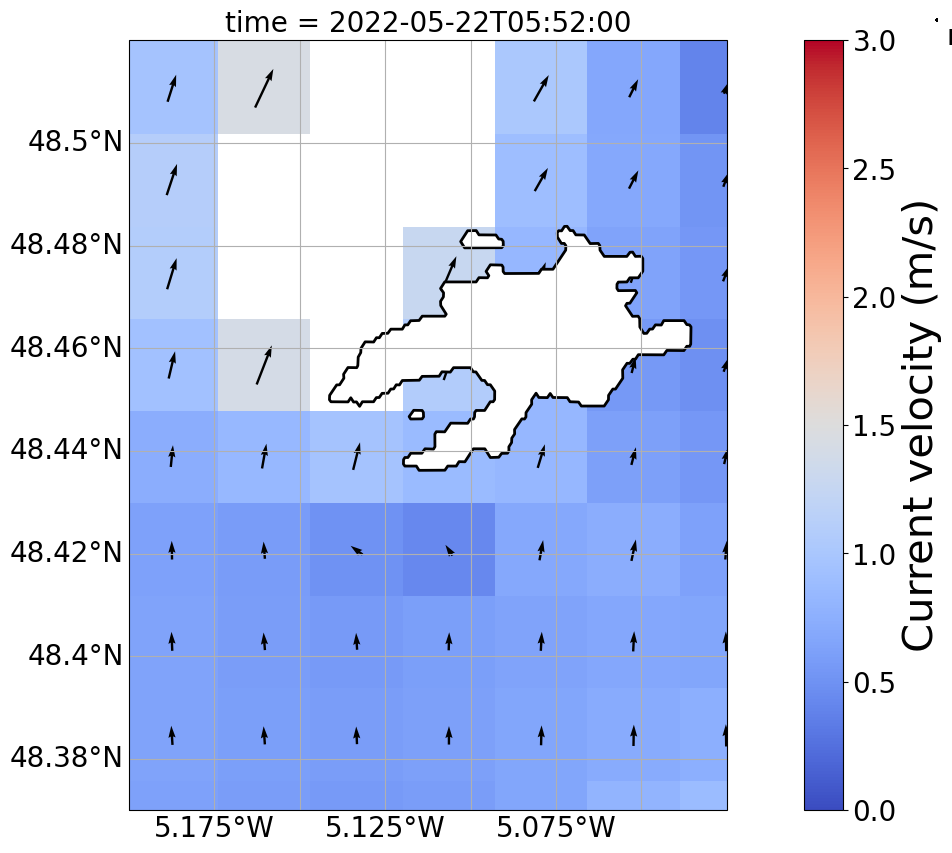

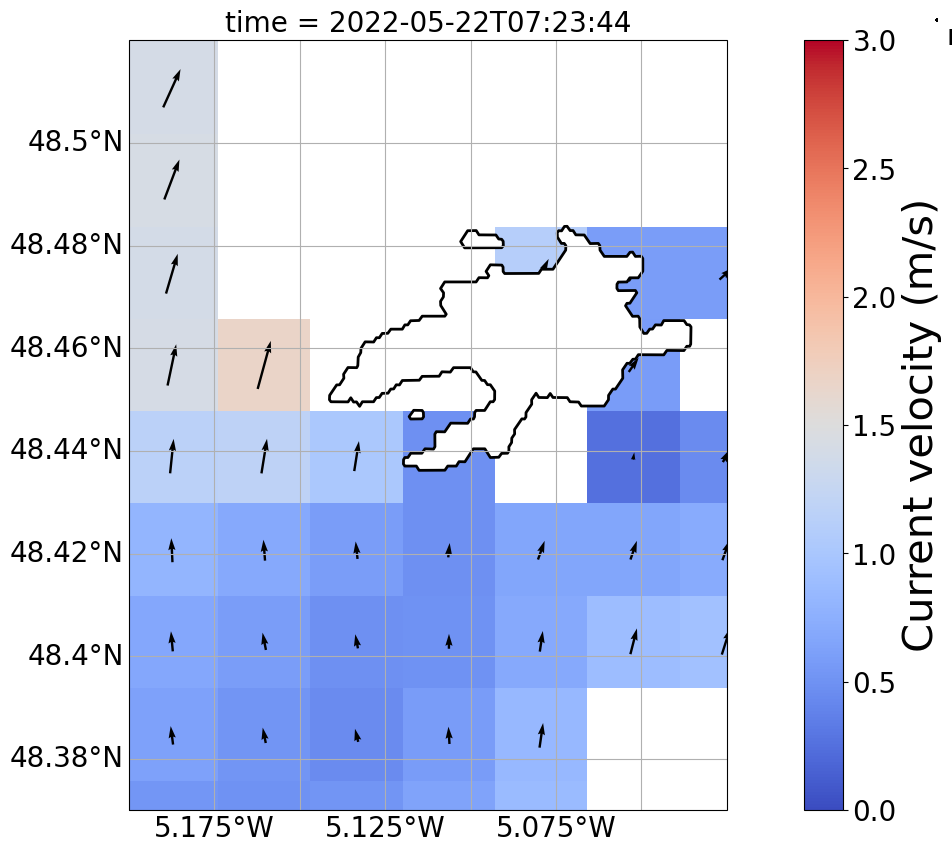

In [164]:
# for track in ['Track_1']:
for track in ds_L2.keys():
    timesel = np.argmin(np.abs(aux_list['HF_combined'].time.data - ds_L1c[track].sel(Antenna='Mid').TrackTime.data))
    plot_pixel_size = 200 #pixel size in metres
    sar_pixel_size = 8
    c_factor = int(plot_pixel_size / sar_pixel_size)
    q_factor = 30 # Quiver plot scaling factor
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator())
    im = aux_list['HF_combined'].CurrentVelocity\
    .isel(time=timesel)\
    .plot(
        y='latitude',
        x='longitude',
        robust=True, 
        cmap='coolwarm',
        vmin=0, vmax=3,
        transform=ccrs.PlateCarree(),
        add_colorbar=False,
    )
#     aux_list['MARS2D']['U_coloc'], aux_list['MARS2D']['V_coloc'] =\
#         ss.utils.tools.currentVelDir2UV(aux_list['MARS2D'].CurrentVelocity,
#                                         aux_list['MARS2D'].CurrentDirection)
    aux_list['HF_combined']\
    .isel(time=timesel)\
    .plot.quiver(
        x='longitude',
        y='latitude',
        u='U',
        v='V',
        scale=20,width=0.004,
        angles='xy',
        robust=True,
        transform=ccrs.PlateCarree()
    )
    #plt.title('MARS2D')
    gl=ax.gridlines(draw_labels=True)
    gl.top_labels=False
    gl.right_labels=False
    ax.set_extent([-5.2, -5.025, 48.37, 48.52], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.GSHHSFeature(scale='full',facecolor='white'), linewidth=2)
    
    cbar = plt.colorbar(im,ax=ax)
    cbar.set_label('Current velocity (m/s)',fontsize=30)
    tracktime = str(np.datetime64(aux_list['HF_combined'].time.isel(time=timesel).data,'m'))
    filetime = tracktime.replace('-','')
    filetime = filetime.replace(':','')
    save_name ='HF_CurrentVelocity_'+'_'+filetime
    plt.title=''
#
    plt.savefig(fig_folder + save_name + '.png', dpi=150, bbox_inches='tight')
    plt.show()

'20220522T0723'